In [1]:
import pickle
import numpy as np
# from ExtractBootlegFeatures import *
from ExtractTest import *
import itertools
import numba as nb
from numba import njit
from collections import defaultdict

In [2]:
import dill
from glob import iglob

**Load in databases and counts**

In [3]:
db_dir = "/data1/kji/databases_v4d/105mill"

In [4]:
d = {}

In [5]:
for filename in iglob(f"{db_dir}/*.pkl", recursive=True):
    combination = filename.split('/')[-1][:-4]
    with open(filename, "rb") as f:
        d[combination] = pickle.load(f)
    print(f"finished {combination}")

finished 015
finished 014
finished 035
finished 02
finished 03
finished 05
finished 013
finished 04
finished 023
finished 025
finished 045
finished 034
finished 01
finished 012
finished 0
finished 024


In [6]:
with open("/data1/kji/databases_random/probabilities.pkl", "rb") as f:
    utilities = pickle.load(f)

In [7]:
with open("num_to_piece_random.pkl", 'rb') as f:
    num_to_piece = pickle.load(f)

In [8]:
combinations = []
for n_gram in range(1, 4):
    combinations += [[0] + list(tup) for tup in itertools.combinations(range(1, 6), n_gram-1)]

In [9]:
combinations = ["".join(str(num) for num in combination) for combination in combinations]

In [10]:
powers = 1 << np.arange(62)[::-1]

In [11]:
def compute_fingerprint(cols):
    fp = []
    equals_Zero = True
    for column in cols:
        hashint = int(column.dot(powers))
        fp.append(hashint)
        if hashint != 0:
            equals_Zero = False
    if equals_Zero == True:
        return None
    return tuple(fp)

In [12]:
def utility(combination, matches):
    return utilities[combination] / matches

In [13]:
def get_ratios(bscore_query, rindex_dict):
    """Inputs: an L x 62 bootleg score query and our dictionary, where
               rindex_dict[fp] = (count, {dictionary of pieces and offsets})
        Output: a 16 X L table where each element is a tuple of (utility:cost ratio, combination, n_gram)"""
    l = len(bscore_query)
    # ratios[i][j] is a pair of (ratio, combination, fingerprint)
    ratios = np.array([[(0, None, None) for _ in range(l)] for _ in range(16)])
    for j in range(l):
        # calculate utility to cost ratio for all 16 n-grams
        for idx, combination in enumerate(combinations):
            cols = []
            # we need at least enough fingerprints for all the indices in our combination
            try:
                for i in combination:
                    cols.append(bscore_query[j+int(i)])
            except IndexError:
                continue
            fp = compute_fingerprint(cols)
            if not fp or combination not in rindex_dict or fp not in rindex_dict[combination]:
                continue
            matches = rindex_dict[combination][fp][0]
            if matches == 0:
                continue
            ratios[idx][j] = (utility(combination, matches), combination, fp)
    return ratios

In [14]:
def update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups):
    if num_lookups == 0:
        return
    for piece in pieces_and_offsets:
#         offset = [(j - i, num_lookups) for j in pieces_and_offsets[piece]]
        if num_lookups <= len(pieces_and_offsets[piece]):
            offset = [j - i for j in pieces_and_offsets[piece][:num_lookups]]
        else:
            offset = [j - i for j in pieces_and_offsets[piece]]
        offset_dict[num_to_piece[piece]].extend(offset)
        num_lookups -= len(pieces_and_offsets[piece])
        if num_lookups <= 0:
            break

In [15]:
def get_fingerprints(bscore_query, rindex_dict, ratios, runtime_budget):
    l = len(bscore_query)
    aisle_budget = runtime_budget // l
    cur_budget = aisle_budget
    offset_dict = defaultdict(list)
    matches_processed = 0
    for i in range(l):
        fingerprints = []
        col = ratios[:, i]
        lookups = sorted(col, key = lambda x: x[0], reverse = True)
        for _, combination, n_gram in lookups:
            if not n_gram or cur_budget < 0:
                break
            matches, pieces_and_offsets = rindex_dict[combination][n_gram]
            if cur_budget - matches < 0:
                num_lookups = cur_budget
            else:
                num_lookups = matches
            update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups)
            cur_budget -= num_lookups
            matches_processed += num_lookups
        cur_budget += aisle_budget
    return offset_dict, matches_processed

In [16]:
def rankHistograms(offset_dict, bin_size=10):
    bin_size = 3
    pieceScores = []
    for key, h in offset_dict.items():
        if not h:
            continue
        maxh = max(h)
        minh = min(h)
        hist = np.zeros(int((maxh-minh)/bin_size)+2)
        for i in h:
            hist[int((i-minh)/bin_size)] += 1
        score = np.max(hist)
        pieceScores.append((key, score))
            
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores

# Increment by length

In [17]:
def update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups, increment):
    if num_lookups == 0:
        return
    for piece in pieces_and_offsets:
        if num_lookups <= len(pieces_and_offsets[piece]):
            offset = [(j - i, increment) for j in pieces_and_offsets[piece][:num_lookups]]
        else:
            offset = [(j - i, increment) for j in pieces_and_offsets[piece]]
        offset_dict[num_to_piece[piece]].extend(offset)
        num_lookups -= len(pieces_and_offsets[piece])
        if num_lookups <= 0:
            break

In [18]:
def get_fingerprints(bscore_query, rindex_dict, ratios, runtime_budget):
    l = len(bscore_query)
    aisle_budget = runtime_budget // l
    cur_budget = aisle_budget
    offset_dict = defaultdict(list)
    matches_processed = 0
    for i in range(l):
        fingerprints = []
        col = ratios[:, i]
        lookups = sorted(col, key = lambda x: x[0], reverse = True)
        for _, combination, n_gram in lookups:
            if not n_gram or cur_budget < 0:
                break
            matches, pieces_and_offsets = rindex_dict[combination][n_gram]
            if cur_budget - matches < 0:
                num_lookups = cur_budget
            else:
                num_lookups = matches
            update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups, len(combination))
            cur_budget -= num_lookups
            matches_processed += num_lookups
        cur_budget += aisle_budget
    return offset_dict, matches_processed

In [19]:
def rankHistograms(offset_dict, bin_size=10):
    bin_size = 3
    pieceScores = []
    for key, h in offset_dict.items():
        if not h:
            continue
        maxh = max(h)[0]
        minh = min(h)[0]
        hist = np.zeros(int((maxh-minh)/bin_size)+2)
        for i, j in h:
            hist[int((i-minh)/bin_size)] += j
        score = np.max(hist)
        pieceScores.append((key, score))
            
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores

# Increment by number of notes

In [106]:
def compute_fingerprint(cols):
    fp = []
    equals_Zero = True
    count = 0
    for column in cols:
        hashint = int(column.dot(powers))
        count += np.count_nonzero(column)
        fp.append(hashint)
        if hashint != 0:
            equals_Zero = False
    if equals_Zero == True:
        return None, None
    return tuple(fp), count

In [124]:
def get_ratios(bscore_query, rindex_dict):
    """Inputs: an L x 62 bootleg score query and our dictionary, where
               rindex_dict[fp] = (count, {dictionary of pieces and offsets})
        Output: a 16 X L table where each element is a tuple of (utility:cost ratio, combination, n_gram, number of notes)"""
    l = len(bscore_query)
    # ratios[i][j] is a pair of (ratio, combination, fingerprint, num_notes)
    ratios = np.array([[(0, None, None, None) for _ in range(l)] for _ in range(16)])
    for j in range(l):
        # calculate utility to cost ratio for all 16 n-grams
        for idx, combination in enumerate(combinations):
            cols = []
            # we need at least enough fingerprints for all the indices in our combination
            try:
                for i in combination:
                    cols.append(bscore_query[j+int(i)])
            except IndexError:
                continue
            fp, num_notes = compute_fingerprint(cols)
            if not fp or combination not in rindex_dict or fp not in rindex_dict[combination]:
                continue
            matches = rindex_dict[combination][fp][0]
            if matches == 0:
                continue
            ratios[idx][j] = (utility(combination, matches), combination, fp, num_notes)
    return ratios

In [125]:
def update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups, increment):
    if num_lookups == 0:
        return
    for piece in pieces_and_offsets:
        if num_lookups <= len(pieces_and_offsets[piece]):
            offset = [(j - i, increment) for j in pieces_and_offsets[piece][:num_lookups]]
        else:
            offset = [(j - i, increment) for j in pieces_and_offsets[piece]]
        offset_dict[num_to_piece[piece]].extend(offset)
        num_lookups -= len(pieces_and_offsets[piece])
        if num_lookups <= 0:
            break

In [135]:
def get_fingerprints(bscore_query, rindex_dict, ratios, runtime_budget):
    l = len(bscore_query)
    aisle_budget = runtime_budget // l
    cur_budget = aisle_budget
    offset_dict = defaultdict(list)
    matches_processed = 0
    for i in range(l):
        fingerprints = []
        col = ratios[:, i]
        lookups = sorted(col, key = lambda x: x[0], reverse = True)
        for _, combination, n_gram, num_notes in lookups:
            if not n_gram or cur_budget < 0:
                break
            matches, pieces_and_offsets = rindex_dict[combination][n_gram]
            if cur_budget - matches < 0:
                num_lookups = cur_budget
            else:
                num_lookups = matches
            update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups, num_notes)
            cur_budget -= num_lookups
            matches_processed += num_lookups
        cur_budget += aisle_budget
    return offset_dict, matches_processed

In [9]:
def rankHistograms(offset_dict, bin_size=10):
    bin_size = 1
    pieceScores = []
    for key, h in offset_dict.items():
        if not h:
            continue
        maxh = max(h)[0]
        minh = min(h)[0]
        hist = np.zeros(int((maxh-minh)/bin_size)+2)
        for i, j in h:
            hist[int((i-minh)/bin_size)] += j
        score = np.max(hist)
        pieceScores.append((key, score))
            
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores

In [17]:
def processSingleQuery(imagefile, rindex, runtime_budget, outfile = None):
    profileStart = time.time()
    
    # Get Bootleg Score
    bscore_query = processQuery(imagefile)
    bscore_query = bscore_query.T
    
    searchStart = time.time()
    # Generate and rank histograms
    
    ratios = get_ratios(bscore_query, rindex)
    offset_dict, matches_processed = get_fingerprints(bscore_query, rindex, ratios, runtime_budget)
    pieceScores = rankHistograms(offset_dict)
    # Profile & save to file
    profileEnd = time.time()
    
    profileDur = profileEnd - profileStart
    print(matches_processed)
    print(profileDur)
    saveToFile(outfile, imagefile, pieceScores, profileDur, matches_processed)
    return pieceScores

In [29]:
processSingleQuery('data/queries/p146_q2.jpg', d, 75000)

Processing data/queries/p146_q2.jpg
73788
1.3429253101348877


[('dBeethoven,_Ludwig_vanPiano_Sonata_No.10,_Op.14_No.2_68725', 49.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.10,_Op.14_No.2_00010', 43.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.10,_Op.14_No.2_243296', 40.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.10,_Op.14_No.2_03033', 34.0),
 ('p146', 34.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.10,_Op.14_No.2_51721', 23.0),
 ('dMicha%C5%82owski,_AleksanderMenuet,_Op.8_357086', 13.0),
 ('dCzerny,_CarlLe_petit_pianiste,_Op.823_356862', 12.0),
 ('dBach,_Johann_SebastianDas_wohltemperierte_Klavier_II,_BWV_870-893_494709',
  12.0),
 ('dLeybach,_Ignace_Xavier_JosephLusignan_marche,_Op.277_371565', 11.0),
 ('dCzerny,_CarlVariations_%C3%A9l%C3%A9gantes_pour_servir_d%27%C3%8Btude,_Op.706_359631',
  11.0),
 ('dKuhlau,_FriedrichPiano_Sonatina_in_C_major,_Op.20_No.1_481782', 10.0),
 ('dStarke,_FriedrichWiener_Pianoforte_Schule,_Op.108_388335', 10.0),
 ('dSchachner,_Joseph_RudolphFantasie_mit_Variationen_%C3%BCber_%27Yankee_Doodle%27,_Op.32_215199',
  

In [22]:
def saveToFile(outfile, imagefile, pieceScores, profileDur, matches_processed):
    if outfile:
        with open(outfile, 'wb') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            pickle.dump((query,pieceScores, profileDur, matches_processed),f)

In [23]:
def processQuery_wrapper(queryfile, rindex, outdir, runtime_budget):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    piece = basename.split('_')[0]
    # might change later to print to outfile
    return processSingleQuery(queryfile, rindex, runtime_budget, hyp_outfile)

In [38]:
outdir = f'experiments/v0.4.0d_test_infinite_budget/hyp' # where to save hypothesis output files

In [40]:
processQuery_wrapper('data/queries/p154_q5.jpg', d, outdir, float('inf'))

Processing data/queries/p154_q5.jpg
869335
2.6287567615509033


[('dMozart,_Wolfgang_AmadeusPiano_Sonata_No.16_in_C_major,_K.545_70214',
  282.0),
 ('p154', 222.0),
 ('dMozart,_Wolfgang_AmadeusPiano_Sonata_No.16_in_C_major,_K.545_00226',
  168.0),
 ('dKuhlau,_FriedrichPiano_Sonatina_in_C_major,_Op.55_No.6_481804', 70.0),
 ('dVo%C5%99%C3%AD%C5%A1ek,_Jan_V%C3%A1clavPiano_Sonata,_Op.20_16469', 67.0),
 ('dMacfarren,_George_AlexanderPiano_Sonata_No.2_%27Ma_Cousine%27_430666',
  60.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.14,_Op.27_No.2_68732', 59.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.14,_Op.27_No.2_32717', 59.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.14,_Op.27_No.2_32718', 58.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.14,_Op.27_No.2_00014', 58.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.14,_Op.27_No.2_15808', 58.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.14,_Op.27_No.2_419635', 58.0),
 ('dRheinberger,_Josef_Gabriel3_Piano_Pieces,_Op.5_110911', 54.0),
 ('dCzerny,_Carl100_Progressive_Studies,_Op.139_81114', 53.0),
 ('dCzerny,_Carl100_Pr

In [34]:
runtime_budget = 65000

In [35]:
query_list = 'cfg_files/query.test.list' # list of query images
outdir = f'experiments/v0.4.0d_test_65k_budget/hyp' # where to save hypothesis output files

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# load reverse index. Recommend keeping load=False and loading it earlier.
load = False
if load:
    print("LOADING RINDEX")
    rindex1 = []
    with open(pickle_file, 'rb') as f:
        rindex1 = pickle.load(f)
    rindex_filter = rindex1

print("STARTING PROCESSING")
# number of cores to use
multiprocess = False
if multiprocess:
    n_cores = 30 #multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=n_cores)

inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), outdir))

if multiprocess:
    # process queries in parallel
    outputs = list(pool.starmap(processQuery_wrapper, inputs))
else:
    for i in inputs:
        processQuery_wrapper(i[0], d, i[1], runtime_budget)

STARTING PROCESSING
Processing data/queries/p2_q1.jpg
61498
1.1509108543395996
Processing data/queries/p2_q2.jpg
63175
0.9128997325897217
Processing data/queries/p2_q3.jpg
64938
0.9375174045562744
Processing data/queries/p2_q4.jpg
64423
0.8511021137237549
Processing data/queries/p2_q5.jpg
63493
0.927365779876709
Processing data/queries/p2_q6.jpg
64431
0.8952105045318604
Processing data/queries/p2_q7.jpg
64536
0.8921806812286377
Processing data/queries/p2_q8.jpg
64271
0.9457862377166748
Processing data/queries/p2_q9.jpg
64078
0.9385473728179932
Processing data/queries/p2_q10.jpg
64190
0.9327030181884766
Processing data/queries/p3_q1.jpg
64144
0.9895718097686768
Processing data/queries/p3_q2.jpg
64136
1.1114528179168701
Processing data/queries/p3_q3.jpg
64496
1.0290563106536865
Processing data/queries/p3_q4.jpg
64400
1.0479583740234375
Processing data/queries/p3_q5.jpg
63336
0.8895697593688965
Processing data/queries/p3_q6.jpg
63876
0.9980337619781494
Processing data/queries/p3_q7.jpg
64

64095
0.9638569355010986
Processing data/queries/p18_q9.jpg
64107
0.9887423515319824
Processing data/queries/p18_q10.jpg
56541
1.1342482566833496
Processing data/queries/p19_q1.jpg
64944
0.8903822898864746
Processing data/queries/p19_q2.jpg
64176
0.8918671607971191
Processing data/queries/p19_q3.jpg
64144
0.8685116767883301
Processing data/queries/p19_q4.jpg
64018
0.8714134693145752
Processing data/queries/p19_q5.jpg
64342
0.9256911277770996
Processing data/queries/p19_q6.jpg
62264
0.8496043682098389
Processing data/queries/p19_q7.jpg
64176
0.940140962600708
Processing data/queries/p19_q8.jpg
63612
0.9640920162200928
Processing data/queries/p19_q9.jpg
63711
1.3848316669464111
Processing data/queries/p19_q10.jpg
62633
0.9794631004333496
Processing data/queries/p20_q1.jpg
62914
0.8413472175598145
Processing data/queries/p20_q2.jpg
64960
0.9281835556030273
Processing data/queries/p20_q3.jpg
64130
0.8522603511810303
Processing data/queries/p20_q4.jpg
59270
0.872244119644165
Processing data

62375
0.7044801712036133
Processing data/queries/p36_q6.jpg
61560
0.90435791015625
Processing data/queries/p36_q7.jpg
64400
0.9016203880310059
Processing data/queries/p36_q8.jpg
63312
1.0684843063354492
Processing data/queries/p36_q9.jpg
63648
0.9196853637695312
Processing data/queries/p36_q10.jpg
64400
0.9886658191680908
Processing data/queries/p37_q1.jpg
64141
0.9122569561004639
Processing data/queries/p37_q2.jpg
64307
0.9339022636413574
Processing data/queries/p37_q3.jpg
63302
0.988231897354126
Processing data/queries/p37_q4.jpg
64916
1.031128168106079
Processing data/queries/p37_q5.jpg
64416
1.0095326900482178
Processing data/queries/p37_q6.jpg
64258
1.0724897384643555
Processing data/queries/p37_q7.jpg
64077
1.063019037246704
Processing data/queries/p37_q8.jpg
63800
1.0365757942199707
Processing data/queries/p37_q9.jpg
64318
1.1117446422576904
Processing data/queries/p37_q10.jpg
62818
0.8762054443359375
Processing data/queries/p38_q1.jpg
63354
0.9289243221282959
Processing data/qu

62832
1.084747552871704
Processing data/queries/p53_q3.jpg
62238
1.0347216129302979
Processing data/queries/p53_q4.jpg
63168
0.9927773475646973
Processing data/queries/p53_q5.jpg
63358
0.9911446571350098
Processing data/queries/p53_q6.jpg
64050
0.9464857578277588
Processing data/queries/p53_q7.jpg
63975
1.0380685329437256
Processing data/queries/p53_q8.jpg
62460
1.0640945434570312
Processing data/queries/p53_q9.jpg
64459
1.0248029232025146
Processing data/queries/p53_q10.jpg
59560
1.0023834705352783
Processing data/queries/p54_q1.jpg
64940
0.9520397186279297
Processing data/queries/p54_q2.jpg
63345
0.9038593769073486
Processing data/queries/p54_q3.jpg
59834
0.88210129737854
Processing data/queries/p54_q4.jpg
63092
0.8508162498474121
Processing data/queries/p54_q5.jpg
63360
0.9328441619873047
Processing data/queries/p54_q6.jpg
64080
0.9401323795318604
Processing data/queries/p54_q7.jpg
58963
0.9162507057189941
Processing data/queries/p54_q8.jpg
57222
0.8960661888122559
Processing data/q

64512
0.964667558670044
Processing data/queries/p69_q10.jpg
64416
1.0015110969543457
Processing data/queries/p70_q1.jpg
63147
1.0502145290374756
Processing data/queries/p70_q2.jpg
64389
0.9304089546203613
Processing data/queries/p70_q3.jpg
64310
1.036560297012329
Processing data/queries/p70_q4.jpg
63840
0.974686861038208
Processing data/queries/p70_q5.jpg
61841
0.884300708770752
Processing data/queries/p70_q6.jpg
62962
1.0930469036102295
Processing data/queries/p70_q7.jpg
62769
0.8583364486694336
Processing data/queries/p70_q8.jpg
63383
0.9023818969726562
Processing data/queries/p70_q9.jpg
64144
1.1228289604187012
Processing data/queries/p70_q10.jpg
63838
0.9417033195495605
Processing data/queries/p72_q1.jpg
63825
0.8290939331054688
Processing data/queries/p72_q2.jpg
64974
0.8434648513793945
Processing data/queries/p72_q3.jpg
63800
0.8167240619659424
Processing data/queries/p72_q4.jpg
63553
0.8119320869445801
Processing data/queries/p72_q5.jpg
63109
0.796311616897583
Processing data/qu

64380
0.911656379699707
Processing data/queries/p87_q7.jpg
62386
0.8918960094451904
Processing data/queries/p87_q8.jpg
62685
0.9530198574066162
Processing data/queries/p87_q9.jpg
64080
1.0584845542907715
Processing data/queries/p87_q10.jpg
64440
1.050400733947754
Processing data/queries/p88_q1.jpg
61774
1.0594744682312012
Processing data/queries/p88_q2.jpg
63434
1.0482099056243896
Processing data/queries/p88_q3.jpg
63607
1.0741441249847412
Processing data/queries/p88_q4.jpg
64943
1.1569569110870361
Processing data/queries/p36_q10.jpg
64400
1.004173994064331
Processing data/queries/p37_q1.jpg
64141
1.0488216876983643
Processing data/queries/p37_q2.jpg
64307
1.1420042514801025
Processing data/queries/p88_q8.jpg
63525
1.1979868412017822
Processing data/queries/p88_q9.jpg
61777
1.0229616165161133
Processing data/queries/p88_q10.jpg
64944
1.0906908512115479
Processing data/queries/p89_q1.jpg
64116
0.8810648918151855
Processing data/queries/p89_q2.jpg
63652
0.9647347927093506
Processing data

63260
1.1426165103912354
Processing data/queries/p104_q4.jpg
64904
1.097069501876831
Processing data/queries/p104_q5.jpg
64093
0.9476594924926758
Processing data/queries/p104_q6.jpg
63960
0.9729068279266357
Processing data/queries/p104_q7.jpg
64260
0.6785364151000977
Processing data/queries/p104_q8.jpg
64288
1.0062649250030518
Processing data/queries/p104_q9.jpg
63960
1.1592292785644531
Processing data/queries/p104_q10.jpg
64400
0.9230132102966309
Processing data/queries/p106_q1.jpg
64813
1.0156328678131104
Processing data/queries/p106_q2.jpg
64225
1.0129733085632324
Processing data/queries/p106_q3.jpg
64603
0.9522993564605713
Processing data/queries/p106_q4.jpg
64080
0.9017541408538818
Processing data/queries/p106_q5.jpg
64952
0.9937789440155029
Processing data/queries/p106_q6.jpg
62837
0.9064793586730957
Processing data/queries/p106_q7.jpg
64493
0.9061002731323242
Processing data/queries/p106_q8.jpg
64094
0.9015259742736816
Processing data/queries/p106_q9.jpg
64084
0.9893476963043213

62921
0.8437786102294922
Processing data/queries/p120_q9.jpg
63945
0.7224164009094238
Processing data/queries/p120_q10.jpg
62721
0.5917894840240479
Processing data/queries/p122_q1.jpg
62150
0.96840500831604
Processing data/queries/p122_q2.jpg
61647
1.0336506366729736
Processing data/queries/p122_q3.jpg
63948
1.0843138694763184
Processing data/queries/p122_q4.jpg
62998
1.013124704360962
Processing data/queries/p122_q5.jpg
58477
0.8780076503753662
Processing data/queries/p122_q6.jpg
63752
1.0292341709136963
Processing data/queries/p122_q7.jpg
62976
0.8630144596099854
Processing data/queries/p122_q8.jpg
57593
0.8681454658508301
Processing data/queries/p122_q9.jpg
63424
1.0643353462219238
Processing data/queries/p122_q10.jpg
64814
1.0262031555175781
Processing data/queries/p123_q1.jpg
64042
0.9534685611724854
Processing data/queries/p123_q2.jpg
63515
0.9715595245361328
Processing data/queries/p123_q3.jpg
64056
0.9704074859619141
Processing data/queries/p123_q4.jpg
64440
1.0001916885375977


63875
0.9395995140075684
Processing data/queries/p138_q4.jpg
63302
0.9972860813140869
Processing data/queries/p138_q5.jpg
63292
0.9447729587554932
Processing data/queries/p138_q6.jpg
64160
0.9572439193725586
Processing data/queries/p138_q7.jpg
64512
0.9726650714874268
Processing data/queries/p138_q8.jpg
64566
0.9554054737091064
Processing data/queries/p138_q9.jpg
64129
1.0026655197143555
Processing data/queries/p138_q10.jpg
64159
0.9540657997131348
Processing data/queries/p139_q1.jpg
47912
0.977597713470459
Processing data/queries/p139_q2.jpg
63443
0.8186731338500977
Processing data/queries/p139_q3.jpg
14997
0.6679654121398926
Processing data/queries/p139_q4.jpg
59170
0.8154125213623047
Processing data/queries/p139_q5.jpg
53381
0.8536651134490967
Processing data/queries/p139_q6.jpg
57542
1.0000686645507812
Processing data/queries/p139_q7.jpg
64944
1.0953238010406494
Processing data/queries/p139_q8.jpg
64980
1.0777931213378906
Processing data/queries/p139_q9.jpg
18682
0.9241886138916016

64454
0.8665285110473633
Processing data/queries/p154_q9.jpg
64800
0.936939001083374
Processing data/queries/p154_q10.jpg
0
0.24625492095947266
Processing data/queries/p156_q1.jpg
64263
0.8894121646881104
Processing data/queries/p156_q2.jpg
64658
0.7655415534973145
Processing data/queries/p156_q3.jpg
64542
0.9720213413238525
Processing data/queries/p156_q4.jpg
64575
1.2281930446624756
Processing data/queries/p156_q5.jpg
64267
1.2164456844329834
Processing data/queries/p156_q6.jpg
64980
1.1066632270812988
Processing data/queries/p156_q7.jpg
64288
0.9110615253448486
Processing data/queries/p156_q8.jpg
63800
1.0302257537841797
Processing data/queries/p156_q9.jpg
64464
0.9344282150268555
Processing data/queries/p156_q10.jpg
64797
0.8891561031341553
Processing data/queries/p157_q1.jpg
58821
1.2593820095062256
Processing data/queries/p157_q2.jpg
63638
0.7860026359558105
Processing data/queries/p157_q3.jpg
64342
0.8815829753875732
Processing data/queries/p157_q4.jpg
64350
0.7702629566192627
P

64446
1.243697166442871
Processing data/queries/p172_q4.jpg
61497
0.9207296371459961
Processing data/queries/p172_q5.jpg
63139
0.942847728729248
Processing data/queries/p172_q6.jpg
64774
1.3884282112121582
Processing data/queries/p172_q7.jpg
62954
1.076786994934082
Processing data/queries/p172_q8.jpg
64887
0.9126040935516357
Processing data/queries/p172_q9.jpg
63539
1.0288701057434082
Processing data/queries/p172_q10.jpg
61080
0.8441474437713623
Processing data/queries/p173_q1.jpg
64471
0.8471720218658447
Processing data/queries/p173_q2.jpg
64471
0.9522192478179932
Processing data/queries/p173_q3.jpg
63051
0.9778099060058594
Processing data/queries/p173_q4.jpg
64258
0.9547922611236572
Processing data/queries/p173_q5.jpg
64246
0.9685969352722168
Processing data/queries/p173_q6.jpg
62307
0.9780251979827881
Processing data/queries/p173_q7.jpg
57038
0.920745849609375
Processing data/queries/p173_q8.jpg
58850
0.9627227783203125
Processing data/queries/p173_q9.jpg
59280
1.0891551971435547
Pr

64300
1.1663212776184082
Processing data/queries/p188_q9.jpg
64468
1.1519033908843994
Processing data/queries/p188_q10.jpg
64240
1.0682926177978516
Processing data/queries/p189_q1.jpg
64094
0.8814401626586914
Processing data/queries/p189_q2.jpg
64090
0.8771741390228271
Processing data/queries/p189_q3.jpg
64528
0.876286506652832
Processing data/queries/p189_q4.jpg
64036
0.9769351482391357
Processing data/queries/p189_q5.jpg
64376
1.0257346630096436
Processing data/queries/p189_q6.jpg
64372
0.9441483020782471
Processing data/queries/p189_q7.jpg
64505
1.0487327575683594
Processing data/queries/p189_q8.jpg
63596
0.968346118927002
Processing data/queries/p189_q9.jpg
64478
1.0606579780578613
Processing data/queries/p189_q10.jpg
64372
0.9593396186828613
Processing data/queries/p190_q1.jpg
63700
0.9920785427093506
Processing data/queries/p190_q2.jpg
64960
1.0346887111663818
Processing data/queries/p190_q3.jpg
63735
1.0015895366668701
Processing data/queries/p190_q4.jpg
62826
0.8296444416046143

In [26]:
n_gram_count = defaultdict(int)

In [27]:
for i in d:
    n_gram_count[i] = len(d[i])

In [28]:
n_gram_count

defaultdict(int,
            {'015': 20250915,
             '014': 19778443,
             '035': 20588831,
             '05': 6245010,
             '013': 18950005,
             '023': 18912434,
             '025': 20576512,
             '045': 20235458,
             '034': 19742801,
             '024': 19719591})

In [29]:
total_matches = 0

In [30]:
for combination in d:
    for fp in d[combination]:
        total_matches += d[combination][fp][0]

In [31]:
total_matches

185000000

## Test code

In [27]:
def get_counts(d):
    """given a database, returns a dictionary mapping each piece to the number of unique fingerprints it has in IMSLP"""
    counts = defaultdict(int)
    for combination in d:
        db = d[combination]
        for fp in db:
            for piece in db[fp][1]:
                counts[piece] += 1
    return counts

In [28]:
def get_coverage(counts, total_pieces):
    """
    given a dictionary of counts, return an array where a[i] is the percent of 
    items in IMSLP with at least i+1 unique fingerprints
    """
    num_pieces_per_count = defaultdict(int)
    for num in counts.values():
        num_pieces_per_count[num] += 1
    n = max(num_pieces_per_count)
    cumulative_counts = []
    cur_count = 0
    for i in reversed(range(1, n+1)):
        cur_count += num_pieces_per_count[i]
        cumulative_counts.append(cur_count)
    return [count / total_pieces for count in cumulative_counts[::-1]]

In [ ]:
counts = get_counts(d)

In [139]:
with open("data/v4b_counts.pkl", "rb") as f:
    counts = pickle.load(f)

In [187]:
for k in l:
    if l[k] < 1000:
        print(k)

p76


In [197]:
l['p118']

3054

<AxesSubplot:ylabel='Count'>

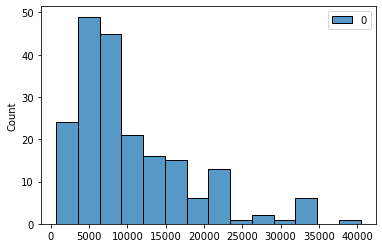

In [174]:
sns.histplot(l.values())

In [176]:
np.mean(list(l.values()))
np.min(list(l.values()))

681

In [ ]:
with open("data/v4c_counts.pkl", "wb") as f:
    pickle.dump(counts, f)

In [ ]:
total = 30275

In [ ]:
percents = get_coverage(counts, total)

In [ ]:
with open("data/percents_v4c.pkl", "wb") as f:
    pickle.dump(percents, f)